# DNNSwift

<p align="center" style="font-size:22;">Rapid Prototyping of Deep Convolutional Neural Networks (DNN)</p>

## Introduction
This python package allows for the rapid training and application of deep neural networks (DNNs). It wraps the Tensorflow package, allowing for easy setup of an architecture without needing to know the nitty-gritty details of how Tensorflow operates.

The focus of this package is to train and apply convolutional DNNs (CNN) with images. One-dimensional data could, hypothetically, be treated as a pseudo-image with the dimensions (N x 1 x 1) (spatial, spatial, channels). This should work but is currently untested.

This vignette will present a example of how to use the package.

## Package contents
The primary class in the package is the 'DNNWrapper', which is the only class with which an end-user needs to directly interact.

- DNNWrapper: A convenience class, which wraps around the interaction of the 'DNN' and 'ImageHandler' classes for the training and application use cases.
- DNN: The core class of the package. This class acts as a container for the neural network structure and offers methods for training the network and applying it to individual images.
- ImageHandler: This class handles the training data.
- Validator: An auxillary class that calculates accuracy metrics.

## Installing the package
The easiest way to install this package is via pip:

    pip install dnnSwift

Alternatively, you can download the 'dnnSwift' directory of this repository and place it in your python path.

## Requirements
The package was tested to work with Python 2.7.12 and requires several additional python packages to function properly:

* tensorflow
* time
* os
* sys
* numpy
* pickle
* pygraphviz
* h5py
* hashlib

All of these packages are either part of the python distribution or can be installed via pip:
    
    pip install <PACKAGE_NAME>

Additionally, the package 'matplotlib' is required in order to run this vignette (but not for the actual package)

## Quick start

Training data for this package must be stored as a single [HDF5](https://support.hdfgroup.org/HDF5/) file. This repository contains a demo data set, a selection of the [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit database for the digits "0", "5", and "7", which shows the expected structure. It can be found in the folder "demo_data"

### Training a Neural network

In [8]:
import dnnSwift

# The layout is a list of dictionaries defining each layer of the DNN. 
# For this example, the DNN will consist of two blocks of 
# "convolution - convolution - maximum pooling", followed by a fully 
# connected layer and finally a cross entropy cost function
dnn_layout = [
    {
        "name": "data",
        "type": "input"
    },
    {
        "name": "conv1",
        "type": "conv",
        "n_kernels": 32,
        "size": (3, 3),
        "stride": (1, 1),
        "padding" : "VALID",
        "input": "data"
    },
    {
        "name": "conv2",
        "type": "conv",
        "n_kernels": 32,
        "size": (3, 3),
        "stride": (1, 1),
        "padding" : "VALID",
        "input": "conv1"
    },
    {
        "name": "maxpool1",
        "type": "maxpool",
        "size": (3, 3),
        "stride": (2, 2),
        "padding" : "VALID",
        "input": "conv2"
    },
    {
        "name": "conv3",
        "type": "conv",
        "n_kernels": 64,
        "size": (3, 3),
        "stride": (1, 1),
        "padding" : "VALID",
        "input": "maxpool1"
    },
    {
        "name": "conv4",
        "type": "conv",
        "n_kernels": 64,
        "size": (3, 3),
        "stride": (1, 1),
        "padding" : "VALID",
        "input": "conv3"
    },
    {
        "name": "maxpool2",
        "type": "maxpool",
        "size": (3, 3),
        "stride": (2, 2),
        "padding" : "VALID",
        "input": "conv4"
    },
    {"name": "fc1", "type": "fc", "input": "maxpool2"},
    {"name": "CrossEntropy", "type": "cross_entropy", "input": "fc1"}]

# This is a dictionary that assigns numerical values to each label. The 
# keys of the dictionary are the actual labels used in the hdf5 file and 
# the values should be integery from 0 to N. Internally, labels are turned 
# into one-hot vectors, so in this set up, "0" becomes (1, 0, 0), "5" 
# becomes (0, 1, 0), and "7" becomes (0, 0, 1)
categories = {"0": 0, "5": 1, "7": 2}

# Initialize the DNN object.
my_dnn = dnnSwift.DNNWrapper(
    categories=categories, layout=dnn_layout)

# The training data must be initialized. This means that the hdf5 file is 
# scanned and the images split into a training, validation, and test set.
# The indices of the lists are written into the 'outfile' as a pickled 
# dictionary.
my_dnn.initialize_training_data(
    filename="demo_data/MNISTDemo.h5", 
    outfile="demo_data/MNISTDemo_split.pkl")

# Train the network. Set 'verbose=True' to see the full output, including 
# the remaining time
my_dnn.train_dnn(
    num_epochs=5, batch_size=128, 
    weights_dir="demo_data/weights", verbose=False)

Epoch 0: Accuracy: 0.948333333333
Epoch 1: Accuracy: 0.983333333333
Epoch 2: Accuracy: 0.985
Epoch 3: Accuracy: 0.993333333333
Epoch 4: Accuracy: 0.993333333333


The _dnnSwift_ object writes its output into the 'weights_dir' directory. The output consists of weights and validation data. Validation data is calculated from data that was not trained on, i.e. it can be used for 1-fold cross validation of the training epochs.

In [9]:
import pickle
import os

# For each epoch, a weights file and a validation file are created. 
# Counting starts at 0, i.e. *_0.pkl is the output AFTER the first epoch!
all_files = os.listdir("demo_data/weights")
print "All Files: "
for f in all_files:
    print "  - %s" % f

All Files: 
  - val_0.pkl
  - val_1.pkl
  - val_2.pkl
  - val_3.pkl
  - val_4.pkl
  - weights_0.pkl
  - weights_1.pkl
  - weights_2.pkl
  - weights_3.pkl
  - weights_4.pkl
  - weights_start.pkl


The validation files are pickled dictionaries containing various metrics. 

In [10]:
with open("demo_data/weights/val_0.pkl", "r") as f:
    val_dat = pickle.load(f)
    keys = val_dat.keys()
    print "Validation file type: " + str(type(val_dat))
    print "Validation file keys:"
    for key in keys:
        print "  - %s" % key

Validation file type: <type 'dict'>
Validation file keys:
  - recall
  - precision
  - rmse_loss
  - top_n_acc
  - top_1_acc
  - counts
  - data_counts
  - cross_entropy_loss


Lets determine the epoch with the best validation accuracy.

In [11]:
val_accs = []
for i in range(5):
    with open("demo_data/weights/val_%s.pkl" % str(i), "r") as f:
        val_accs.append(pickle.load(f)["top_1_acc"])
best_epoch = val_accs.index(max(val_accs))
print "Validation accuracies:"
for val_acc in val_accs:
    print "  - %.4f" % val_acc
print "Best epoch: %s" % str(best_epoch)

Validation accuracies:
  - 0.9483
  - 0.9833
  - 0.9850
  - 0.9933
  - 0.9933
Best epoch: 3


We've already seen that "top_1_acc" represents the top-1 accuracy. This is a common measure for determining the accuracy of neural networks. It represents the probability of the network correctly predicting the class of a validation data point. Additionally, the top-N accuracy is also calculated. This is the probability that the label of a validation data point is in the top N most likely classes predicted by the neural network.

This is calculated for $1 <= N <= \# Categories$. Here we have three categories into which we classify images.

In [14]:
with open("demo_data/weights/val_0.pkl", "r") as f:
    val = pickle.load(f)["top_n_acc"]

for key in val.keys():
    print "Top-%s accuracy: %s" % (key, val[key])

Top-1 accuracy: 0.948333333333
Top-2 accuracy: 0.995
Top-3 accuracy: 1.0


Beyond that, we can also calculate the precision-recall curves from the "precision" and "recall" keys. These entries contain nested dictionaries and are calculated for each label independently. They are calculated for various probability thresholds. That means that instead of naively using the highest probability to determine the class, one can set custom thresholds for each category.

In [15]:
import matplotlib.pyplot as plt

# Precision and Recall are calculated for each category individually
print "Labels: " + str(best_val["precision"].keys())

NameError: name 'best_val' is not defined

In addition to the precision and recall, the number of items predicted for each category at each threshold level is also stored. This can be useful for computing averages of precision and recall between categories. Note that this is **not** the total number of elements for each class in the validation data, but the number of elements predicted by the DNN, correct or not.

Let's look at the precision-recall curves for the digit "5". Precision and Recall are calculated for various probability thresholds. 

In [84]:
# We'll use the result of the first epoch to make the curve at least 
# somewhat interesting
with open("demo_data/weights/val_0.pkl", "r") as f:
    val_dat = pickle.load(f)
    precision = val_dat["precision"]["5"]
    recall = val_dat["recall"]["5"]
    counts = val_dat["counts"]["5"]

# The disadvantage of using a dictionary is that the entries are not 
# sorted. Future versions of this package may use a different storage 
# method for the validation
p_thresh, p_val = zip(*precision.items())
sort_indices = [p_thresh.index(p) for p in sorted(p_thresh, key=lambda x: float(x))]
p_thresh = [float(p_thresh[i]) for i in sort_indices]
p_val = [p_val[i] for i in sort_indices]
    
r_thresh, r_val = zip(*recall.items())
sort_indices = [r_thresh.index(r) for r in sorted(r_thresh, key=lambda x: float(x))]
r_thresh = [float(r_thresh[i]) for i in sort_indices]
r_val = [r_val[i] for i in sort_indices]

c_thresh, c_val = zip(*counts.items())
sort_indices = [c_thresh.index(c) for c in sorted(c_thresh, key=lambda x: float(x))]
c_thresh = [float(c_thresh[i]) for i in sort_indices]
c_val = [c_val[i] for i in sort_indices]

# The thresholds for all categories are identical:
assert(p_thresh == r_thresh == c_thresh)

# A value of 'nan' indicates that nothing was predicted, correctly or not, 
# with the given probability threshold.
print "Threshold | Precision |   Recall  | Counts"
print "--------------------------------------------"
for i in range(len(p_thresh)):
    print "%8.4f  |" % p_thresh[i], \
        "%8.4f  |" % p_val[i], \
        "%8.4f  |" % r_val[i], \
        "%5d" % c_val[i]
print "--------------------------------------------"

Threshold | Precision |   Recall  | Counts
--------------------------------------------
  0.3333  |   0.8831  |   0.9808  |   231
  0.3684  |   0.8831  |   0.9808  |   231
  0.4035  |   0.8831  |   0.9808  |   231
  0.4386  |   0.8831  |   0.9808  |   231
  0.4737  |   0.8831  |   0.9808  |   231
  0.5088  |   0.8904  |   0.9760  |   228
  0.5439  |   0.8973  |   0.9663  |   224
  0.5789  |   0.9000  |   0.9519  |   220
  0.6140  |   0.9037  |   0.9471  |   218
  0.6491  |   0.9206  |   0.9471  |   214
  0.6842  |   0.9286  |   0.9375  |   210
  0.7193  |   0.9327  |   0.9327  |   208
  0.7544  |   0.9409  |   0.9183  |   203
  0.7895  |   0.9397  |   0.8990  |   199
  0.8246  |   0.9436  |   0.8846  |   195
  0.8596  |   0.9468  |   0.8558  |   188
  0.8947  |   0.9607  |   0.8221  |   178
  0.9298  |   0.9620  |   0.7308  |   158
  0.9649  |   0.9767  |   0.6058  |   129
  1.0000  |      nan  |   0.0000  |     0
--------------------------------------------


## Imports for this vignette
These imports are used throughout the vignette. When running the code yourself, be sure to always run this block first.

In [1]:
from __future__ import division
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## ImageHandler: Initializing and Handling of Training Data
All training data is handled by the *ImageHandler* class. It expects training data to be in the [HDF5 file format](https://support.hdfgroup.org/HDF5/). The structure of this file must be as follows:

    - FILE
      - DATASET "images"
        - SHAPE (Number of Images, Image Channels, Spatial Dimension, Spatial Dimension)
      - DATASET "labels"
        - SHAPE (Number of Images, 1)

The dataset *images* effectively contains a 4D numpy array with the aforementioned shape. The dataset *labels* contains a 2D numpy array of label names, e.g.

    array([['Label_A'],
           ['Label_A'],
           ['Label_B'],
           ['Label_B'],
           ['Label_B'],
           ['Label_C'],
           ['Label_C'],
           ['Label_A']], 
          dtype='|S7')

The *ImageHandler* class automatically turns the string labels into one-hot vectors, e.g. (1, 0, 0, 0), with the appropriate dimensions. Note that the dataset names, *images* and *labels* can be changed; custom names can be passed to the *ImageHandler* constructor.

Note that the data file may, of course, have additional data sets (e.g. to store metadata). These are simply ignored.

### Generating a Training Data HDF5 file
For this demonstration, I generate a dataset consisting of noisy circles and squares, which we want to classify with a DNN.

In [2]:
# The size of our image segments (both dimensions have the same size)
img_dims = 25

# The number of images in each class
num_images = 10000

max_rad = ((img_dims - 1) // 2) - 1
center = (img_dims - 1) // 2
ind_y, ind_x = np.indices(dimensions=(img_dims, img_dims)) - center

# Circles
rand_rads = np.random.randint(5, max_rad+1, num_images)
rand_intensities = np.random.randint(1, 256, num_images)
noise_field = np.random.randint(-32, 33, (img_dims, img_dims, num_images))
rad_field = np.repeat(np.expand_dims(np.sqrt(ind_y**2 + ind_x**2), 2), num_images, 2) <= rand_rads
img_circles = (rad_field.astype(dtype=np.int16) * rand_intensities) + noise_field
img_circles[img_circles < 0] = 0
img_circles[img_circles > 255] = 255

# Squares
rand_rads = np.random.randint(5, max_rad+1, num_images)
rand_intensities = np.random.randint(1, 256, num_images)
noise_field = np.random.randint(-32, 33, (img_dims, img_dims, num_images))
ind_x_square = np.repeat(np.expand_dims(ind_x, 2), num_images, 2)
ind_y_square = np.repeat(np.expand_dims(ind_y, 2), num_images, 2)
square_field = (np.abs(ind_x_square) <= rand_rads) * (np.abs(ind_y_square) <= rand_rads)
img_squares = (square_field.astype(dtype=np.int16) * rand_intensities) + noise_field
img_squares[img_squares < 0] = 0
img_squares[img_squares > 255] = 255

imgs = np.concatenate((img_circles, img_squares), 2)
imgs = np.transpose(imgs, (2, 0, 1))
imgs = np.expand_dims(imgs, 1)
imgs = imgs.astype(np.uint8)
labels = np.expand_dims(np.repeat(("Circle", "Square"), (num_images, num_images)), 1)

with h5py.File("TrainingData.h5", "w") as h5handle:
    h5handle.create_dataset(name="images", data=imgs, chunks=(1, 1, img_dims, img_dims), compression=3)
    h5handle.create_dataset(name="labels", data=labels, chunks=(1, 1), compression=3)

The resulting file, *TrainingData.h5*, has the following structure:

In [3]:
with h5py.File("TrainingData.h5", "r") as h5handle:
    print "Entries: ", h5handle.keys()
    print h5handle["images"]
    print h5handle["labels"]

Entries:  [u'images', u'labels']
<HDF5 dataset "images": shape (20000, 1, 25, 25), type "|u1">
<HDF5 dataset "labels": shape (20000, 1), type "|S6">


### Loading the Training Data

*ImageHandler* reads this file and prepares the data for the DNN class. 

In [4]:
import DNNSwift
img_handler = DNNSwift.ImageHandler.initialize(
    filename="TrainingData.h5", 
    categories={"Circle": 0, "Square": 1})

The *categories* argument assigns numerical values to each label. The output of a tensorflow neural network is a vector of numbers, which can be interpreted as probabilities after the proper normalization. The integer value of the *categories* dictionary indicates the order of labels, i.e. in this case 'Circle' is assigned to the one-hot vector (1,0) and 'Square' to the one-hot vector (0,1). A normalized output of (0.4,0.6) would then be interpreted as a 60% probability for the input image being a square.

*ImageHandler* randomly splits apart the entire dataset into three groups for training, (cross-)validation, and testing and internally stores the image indices belonging to each group. Note that the order of images is randomized, during this split so that the data order in the hdf5 file is not preserved at runtime.

In [5]:
for list_name in img_handler.get_list_names():
    print list_name, ":: Length:", img_handler.get_list_length(list_name)

test :: Length: 2000
train :: Length: 16000
val :: Length: 2000


By default, the split is 80%-10%-10% (Training, Validation, Testing), but this can be customized via the *data_split* argument of the constructor. It expects a list of values indicating the relative sizes of each image set (in order: training, validation, testing). The numbers are normalized internally so can be arbitrarily large. 

Likewise, the custom names for the HDF5 datasets can also be passed to the *ImageHandler* constructor via the arguments *image_key* and *label_key*, if so desired.

In [6]:
img_handler = DNNSwift.ImageHandler.initialize(
    filename="TrainingData.h5", 
    categories={"Circle": 0, "Square": 1},
    data_split=[60, 20, 20])

The image split can be saved. If, for whatever reason, the network needs to be revalidated or training is interrupted and continued, the identical training dataset must be used. For this reason, *ImageHandler* can also be initialized with an index list, preventing the creation of a new one.

In order to ensure that the HDF5 file with the training data is unchanged, the md5sum of this file is calculated and stored in the file containing the image group split.

In [7]:
img_handler.save_lists("IndexLists.pkl")    

In [8]:
import pickle
with open("IndexLists.pkl", "r") as f:
    index_file = pickle.load(f)
    
print "Keys:", index_file.keys()
print "Index Lists:"
for key in index_file["index_list"].keys():
    print "  ", key, ":", index_file["index_list"][key]
print "md5sum:", index_file["h5file_hash"]

img_handler = DNNSwift.ImageHandler.initialize_with_index_list(
    filename="TrainingData.h5", 
    categories={"Circle": 0, "Square": 1}, 
    index_list=index_file)

Keys: ['h5file_hash', 'index_list']
Index Lists:
   test : [10555 13641  8198 ...,  9972 10937 13895]
   train : [ 5994 15295  4350 ...,  5423  1479  3371]
   val : [15712    82  3498 ...,  7921  1774  7309]
md5sum: 885cd4ffb20867e700a43905179c284a


Images can be extracted directly from the image handler. This returns a custom object with the attributes "imgs" and "labels", which hold the image and label data, respectively. Note that *index_high* is an inclusive index, as opposed to python's usual indexing logic of excluding the upper limit. Ergo, setting 

    index_low == index_high 

returns a single image.

Object type: <DNNSwift.ImageHandler.ImagesAndLabels object at 0x13467d890>
images.imgs: <type 'numpy.ndarray'> ; (10, 25, 25, 1)
images.labels: <type 'numpy.ndarray'> ; (10, 2)


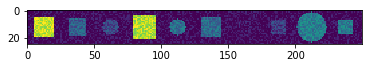

In [9]:
images = img_handler.get_images(list_name="test", index_low=0, index_high=9)
print "Object type:", images
print "images.imgs:", type(images.imgs), ";", images.imgs.shape
print "images.labels:", type(images.labels), ";", images.labels.shape

plt.imshow(np.concatenate(images.imgs[..., 0], axis=1))

## Initializing the DNN
The architecture of the DNN is defined in a layout file that has the structure of a list of python dictionaries, e.g.:

    [{name: "A", type: "conv", ...},
     {name: "B", type: "conv", ...}, 
     {name: "C", type: "fc", ...}]

Each dictionary corresponds to a single node, or layer, in the DNN. The type of node is defined via the 'type' key. The currently supported nodes and the required dictionary keys are:

* Input Layer ('input')
    * In tensorflow terminology, this is a *placeholder* into which data is loaded at run-time.
    * Required / Supported keys:
        * name: (str) A unique name for the node
        * type: 'input'
        * data_z_index: (list or integer) The input data can be split along the z-axis/channels. This list (or integer) indicates which z-layers/channels of the input data should be read into this particular input node. If this is missing, the class assumes all layers are to be used as input. This is useful, for example, if each color channel of an image should be trained on independently rather than together with the other channels. Convolutions on 3D images, at least in Tensorflow, are across all dimensions simultaneously. If the individual channels are independent, however (e.g. in biological images with N staining channels), then this can lead to a significant reduction in classification accuracy, see [here](http://biorxiv.org/content/early/2016/11/02/085118). 
* Convolution ('conv')
    * A standard tensorflow convolution across the input data
    * Required / Supported keys:
        * name: (str) A unique name for the node
        * type: 'conv'
        * input: (str) The name of the input node for this convolution, i.e. the node that feeds its output into the convolution
        * size: (tuple of integers) The size of the convolutional kernel across the spatial dimensions. The convolution is performed across all channels at once, there is currently no provision for having a convolution across, for example, two of three channels at a time. This might be a useful addition later on if, for example, one were to feed time series data into the DNN
        * n_kernels: (integer) The number of independent kernels to use. A convolution layer with N kernels outputs a feature map with N channels.
        * stride: (tuple of integers) The size of the steps to take for the convolution, i.e. a stride of N means that the convolution is only performed every N-th pixel (e.g. to avoid overlaps)
        * padding: (str) Must have a value permitted by tensorflow (currently only "VALID", i.e. the convolution is only performed when the kernel is completely inside the image, or "SAME", the outside of the image is padded with the nearest pixel value to allow a convolution even at the border)
* Maximum Pooling ('maxpool')
    * A maximum pooling operation that returns only the largest value in a given window
    * Required / Supported keys:
        * name: (str) A unique name for the node
        * type: 'maxpool'
        * input: (str) The name of the input node for the maximum pooling, i.e. the node that feeds its output into the maximum pooling
        * size: (tuple of integers) The size of the maxpool kernel across the spatial dimensions. Maximum pooling is performed channel-wise. At the time of development, tensorflow did not support pooling across channels
        * stride: (tuple of integers) The size of the steps to take for the maxpool operation, i.e. a stride of N means that the pooling is only performed every N-th pixel (e.g. to avoid overlaps)
        * padding: (str) Must have a value permitted by tensorflow (currently only "VALID", i.e. the pooling is only performed when the kernel is completely inside the image, or "SAME", the outside of the image is padded with the nearest pixel value to allow pooling even at the border)
* Fully Connected ('fc')
    * Fully connected layers are used in classification but not segmentation. To allow for flexibility between the two tasks, the FC-functionality is implemented as a convolution with the size of the input and a "VALID" padding, so that the output is a (1 x 1 x K) feature vector, where K is the number of 'pseudo-convolutional' kernels used.
    * Required / Supported keys:
        * name: (str) A unique name for the node
        * type: 'fc'
        * input: (str) The name of the input node for the fc layer, i.e. the node that feeds its output into the fc layer
        * **[optional]** n_kernels: (integer) If n_kernels is given as a dictionary key, then the layer will consist of the corresponding number of convolutions/fully connected features. If this key is missing, however, the class will automatically create as many output features as there are categories in the training data so that the output can be normalized and interpreted as a probability for each category. The last operational layer of each network (before the definition of the loss function) should be a fully connected layer without a *n_kernels' parameter
* Concatenation ('concat')
    * Combines multiple input tensors along the channel axis. E.g. if two feature arrays, each with 128 channels, are concatenated, then this layer outputs a feature array with 256 channels
    * Required / Supported keys:
        * name: (str) A unique name for the node
        * type: 'concat'
        * input: (tuple of str) A list of names of input nodes for the concatenation layer. This **must** be an iterable object (list, tuple, numpy array), even if, for whatever reason, only a single layer serves as input.
* Inception ('inception')
    * A compound block inspired by Google's [inception architecture](https://github.com/tensorflow/models/tree/master/inception). A block consists of N independent branches, each with a varying kernel size, that are concatenated to a single feature array at the end. An example of such a block is shown here: 
    
    ![InceptionBlock](inception_module.jpg)
    
    The pooling and convolutions are performed in a way that results in the output feature array having the same spatial dimensions as the input layer. To further reduce computational time, NxN convolutions are split into an Nx1 and 1xN convolution ([Separable Convolutions](https://arxiv.org/abs/1610.02357)).
    * Required / Supported keys:
        * name: (str) A unique name for the node
        * type: 'inception'
        * input: (str) The name of the input node for the inception layer, i.e. the node that feeds its output into the inception layer
        * branches: (tuple of ints) The 1x1 convolution as well as the pooling+1x1 convolution branches are always created. Additional branches, i.e. kernel sizes, are defined via this parameter. For example, to create an inception module with the branches shown in the image above, branches must be set to (3, 5). Duplicate kernel sizes are ignored.
        * n_kernels: (int) The 1x1 convolution in each branch is used to "downsample" the input feature array in order to optimize computation time. This parameter determines how many feature maps each branch outputs. The final output of the inception is a concatenation of all branch outputs, so accordingly it has n_kernels * number of branches feature maps.
* Loss Function / Optimizer ('cross_entropy' / 'rmse')
    * This is not an operational node but the loss function that will be used by the gradient descent algorithm when training the algorithm. Even if the DNN will only be used for application and not training, a loss function must still be defined (but will then be ignored). There may be only one loss function defined in the layout file. Currently permitted loss functions are the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) and the root mean square error.
    * Required / Supported keys:
        * name: (str) A unique name for the node
        * type: 'cross_entropy' or 'rmse'
        * input: (str) The name of the input node for the loss function, i.e. the last operational layer of the network (usually the unnormalized probability vector for each category)
        * optimizer_type: This must be a native tensorflow optimizer (defaults to tensorflow.train.AdamOptimizer)

An example of a layout file is given below. This layout takes input data with three channels and passes each channel through an independent node chain before concatenating the results:

    {"name": "data_ch1", "type": "input", "data_z_index": [0]},
    {"name": "data_ch2", "type": "input", "data_z_index": [1]},
    {"name": "data_ch3", "type": "input", "data_z_index": [2]},
    {"name": "conv1_ch1", "type": "conv", "n_kernels": 64, "size": (3, 3), 
     "stride": (1, 1), "padding": "VALID", "input": "data_ch1"},
    {"name": "conv1_ch2", "type": "conv", "n_kernels": 64, "size": (3, 3),
     "stride": (1, 1), "padding": "VALID", "input": "data_ch2"},
    {"name": "conv1_ch3", "type": "conv", "n_kernels": 64, "size": (3, 3),
     "stride": (1, 1), "padding": "VALID", "input": "data_ch3"},
    {"name": "incep1_ch1", "type": "inception", "input": "conv1_ch1", 
     "n_kernels": 32, "branches": (3, 5, 7)},
    {"name": "incep1_ch2", "type": "inception", "input": "conv1_ch2", 
     "n_kernels": 32, "branches": (3, 5, 7)},
    {"name": "incep1_ch3", "type": "inception", "input": "conv1_ch3", 
     "n_kernels": 32, "branches": (3, 5, 7)},
    {"name": "maxpool_after_incep1_ch1", "type": "maxpool", "size": (3, 3), 
     "stride": (2, 2), "padding": "SAME", "input": "incep1_ch1"},
    {"name": "maxpool_after_incep1_ch2", "type": "maxpool", "size": (3, 3), 
     "stride": (2, 2), "padding": "SAME", "input": "incep1_ch2"},
    {"name": "maxpool_after_incep1_ch3", "type": "maxpool", "size": (3, 3), 
     "stride": (2, 2), "padding": "SAME", "input": "incep1_ch3"},
    {"name": "fc_ch1", "type": "fc", "n_kernels": 32, 
     "input": "maxpool_after_incep1_ch1"},
    {"name": "fc_ch2", "type": "fc", "n_kernels": 32, 
     "input": "maxpool_after_incep1_ch2"},
    {"name": "fc_ch3", "type": "fc", "n_kernels": 32, 
     "input": "maxpool_after_incep1_ch3"},
    {"name": "concat_channels", "type": "concat", 
     "input": ["fc_ch1", "fc_ch2", "fc_ch3"]},
    {"name": "output", "type": "fc", "input": "concat_channels"},
    {"name": "CrossEntropy", "type": "cross_entropy", "input": "output"}

For the training data, however, a much simpler DNN will suffice to classify the images. The structure of this network is:


In [10]:
dnn_layout = [{"name": "input", "type": "input"},
             {"name": "conv1", "type": "conv", "n_kernels": 32, "size": (3, 3), 
              "stride": (1, 1), "padding" : "VALID", "input": "input"}, 
             {"name": "conv2", "type": "conv", "n_kernels": 32, "size": (3, 3), 
              "stride": (1, 1), "padding" : "VALID", "input": "conv1"},
             {"name": "maxpool1", "type": "maxpool", "size": (3, 3), 
              "stride": (2, 2), "padding" : "VALID", "input": "conv2"},
             {"name": "conv3", "type": "conv", "n_kernels": 64, "size": (3, 3), 
              "stride": (1, 1), "padding" : "VALID", "input": "maxpool1"},
             {"name": "conv4", "type": "conv", "n_kernels": 64, "size": (3, 3), 
              "stride": (1, 1), "padding" : "VALID", "input": "conv3"},
             {"name": "maxpool2", "type": "maxpool", "size": (3, 3), 
              "stride": (2, 2), "padding" : "VALID", "input": "conv4"},
             {"name": "fc1", "type": "fc", "input": "maxpool2"},
             {"name": "CrossEntropy", "type": "cross_entropy", "input": "fc1"}]

The network wrapper is initialized via:

In [11]:
trainer = DNNSwift.DNN(
    img_dims=img_handler.get_image_dims(), 
    labels=img_handler.get_image_groups(), 
    layer_params=dnn_layout, 
    basedir="dnn_output")

The required parameters are as follows:
* img_dims: The dimension of the training images (spatial, spatial, channels), e.g. (21, 21, 3)
* labels: The same label dictionary used for the ImageHandler class
* layer_params: The list of dictionaries defining the network structure
* basedir: The base directory into which training and validation results should be written (note that this directory must exist, this package does not create it).

Optional parameters may also include:
* weights (defaults to None): A dictionary of values with which to initialize the network (see further below for more information on this). If not explicitly defined (or defined as 'None') then random weights are chosen.
* learning_rate (defaults to 1e-3): The initial learning rate of the DNN (note that depending on the optimizer chosen, the learning rate will be changed throughout the training process

An image of the network structure can be created via:

In [12]:
trainer.print_structure(filename="DNN_Structure.png")

The *filename* is the relative path under the objects *basedir* folder. The output type is defined by the file ending, e.g. \*.png outputs an image. The full list of permitted output types can be found at the [PyGraphViz](https://pygraphviz.github.io/) homepage.

## Training the Network
Running the network training after initialization is as simple as executing the command

In [13]:
trainer.train_network(
    batch_size=128, 
    image_handler=img_handler, 
    num_epochs=1,
    subdir="weights", 
    logfile="dnn_output/DNN_log.txt")

The required parameters are as follows:
* batch_size: Stochastic gradient descent methods train data in batches, meaning a number of images are put through the network and their respective losses are averaged prior to parameter adjustment. This significantly decreases the time required to train a network to convergence and also helps avoid local minima.
* image_handler: The ImageHandler object instantiated earlier, which holds the training data
* num_epochs: The number of iterations over the training data. For training neural networks via stochastic gradient descent, it is common to train the network on the same data repeatedly until convergence. In each iteration, the training data is randomly shuffled and grouped into new batches.

Optional parameters may also include:
* subdir (defaults to "."): The subdirectory (under the object's *basedir* declared above) into which to save the weights and validation data. 'subdir' **is** created if it does not exist
* logfile (defaults to None): The file into which to write the training status. If 'None', then output is written to the standard output (e.g. command line). Appends to the file if it already exists. Requires an absolute path to enable integration of the class with other code.
* vebose (defaults to True): If this is set to 'True', then detailed outputs are shown (including the time remaining and the number of batches processed in the current epoch). If 'False', then only the validation accuracy at the end of the epoch is shown.
* start_epoch (defaults to 0): It may be necessary to continue training from a specific epoch and retain consistency with the epoch naming. This is the epoch at which to continue training.

The *DNN* class uses the validation subset of the training data to perform a cross-validation of the state of the network. The calculation and file writing are handled entirely by the *Validator* class (and its *save_results()* method). The file contains a python dictionary with the keys:
* precision/recall/counts: Precision/Recall statistics for each image class. This also includes the number of elements identified for each category (correctly or incorrectly) for the purpose of determining a weighted average of PR curves.
* top_1_acc: The 'top-1 accuracy', i.e. the number of elements correctly identified with their proper labels
* cross_entropy_loss/rmse_loss: The mean values of the loss functions (cross entropy and root mean squared error) for the validation data. Both of these are calculated, regardless of which loss function was actually used for the training, for informational purposes.

In [14]:
import pickle
with open("dnn_output/weights/val_0.pkl", "r") as f:
    val_dat = pickle.load(f)
print "Keys:", val_dat.keys()
print "Validation Accuracy:", val_dat["top_1_acc"]

Keys: ['recall', 'precision', 'rmse_loss', 'top_1_acc', 'cat_collapse_acc', 'counts', 'cross_entropy_loss']
Validation Accuracy: 0.9615


The trained parameters ('weights') are output as as pickled python dictionary. For each node with a set of parameters (i.e. convolutions and all derivatives), two keys exist in the dictionary, 'node_name/w' and 'node_name/b' for the multiplicative weights and the biases, respectively. The values of each dictionary entry is a numpy array:

In [15]:
with open("dnn_output/weights/weights_0.pkl", "r") as f:
    weights = pickle.load(f)
keys = sorted(weights.keys())
for key in keys:
    print key, ":", weights[key].shape

conv1/b : (32,)
conv1/w : (3, 3, 1, 32)
conv2/b : (32,)
conv2/w : (3, 3, 32, 32)
conv3/b : (64,)
conv3/w : (3, 3, 32, 64)
conv4/b : (64,)
conv4/w : (3, 3, 64, 64)
fc1/b : (2,)
fc1/w : (2, 2, 64, 2)


If initializing a DNN with non-random weights, the dictionary **must** have two keys for each layer that requires parameters with the expected shape: (spatial, spatial, input channels, num_kernels/output_channels)

## Applying the network
The DNN, once trained, can also be applied to images. The output is a vector of (unnormalized) probabilities for each category (the indices of the output vectors correspond to the numerical values given to each category as defined above). There are several "extra" dimensions in the numpy array due to tensorflow's internal logic. For consistency, these are included in the output and can be 'squeezed' away for easier handling.

In [16]:
# Initialize the object with the optimal set of weights
trainer = DNNSwift.DNN(
    img_dims=img_handler.get_image_dims(), 
    labels=img_handler.get_image_groups(), 
    layer_params=dnn_layout, 
    basedir="dnn_output",
    weights=weights)

images = img_handler.get_images("test", 0, 9)
output = trainer.run_network(input_images=images.imgs)
print "Output shape:", output.shape
print "Output:\n", np.squeeze(output)
print "Image Categories:", img_handler.get_image_groups()

Output shape: (10, 1, 1, 2)
Output:
[[  6.32994604e+00   2.65618057e+01]
 [  3.14977169e+00   9.42996693e+00]
 [  8.00156784e+00   4.46643174e-01]
 [  6.08139038e+00   2.32556953e+01]
 [  1.31521511e+01   9.78497982e-01]
 [  2.64972854e+00   1.03727827e+01]
 [  9.80003834e-01   1.47008562e+00]
 [  3.31285906e+00   4.99898243e+00]
 [  1.37556057e+01  -2.84361839e-03]
 [  4.25528145e+00   1.25044174e+01]]
Image Categories: {'Circle': 0, 'Square': 1}


Comparing the input labels with the output logits:

In [17]:
print "Network Output:", np.argmax(np.squeeze(output), axis=1)
print "Ground Truth:  ", np.argmax(images.labels, axis=1)

Network Output: [1 1 0 1 0 1 1 1 0 1]
Ground Truth:   [1 1 0 1 0 1 0 1 0 1]


Optional parameters for 'run_network()':
* batch_size: Tensorflow can process multiple images simultaneously. However, attempting to load too many images into the network simultaneously leads to a memory bottleneck and drastically slows down operation. Instead, images are loaded into batches (default size: 1000) and batches are then processed in sequence. The optimal batch size may be very system dependent so if you experience unexpected slowdowns when increasing the number of input images, play around with this number.

The package also supports running a network on input images of a different size than the images trained on. This can be useful for segmentation if the network is trained on small segments (e.g. foreground/background) of full images. To apply the network to a different image size, the DNN object must be instantiated again with a different *img_dims* argument. For example, let us construct an artificial image from four training images: 

Big Image shape: (1, 50, 50, 1)


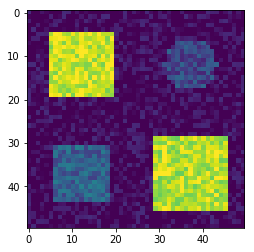

In [18]:
images = img_handler.get_images("test", 0, 3)
big_image = np.concatenate(
    (np.concatenate((images.imgs[0], images.imgs[1]), axis=0),
     np.concatenate((images.imgs[2], images.imgs[3]), axis=0)),
    axis=1)
big_image = np.expand_dims(big_image, axis=0)
print "Big Image shape:", big_image.shape

plt.imshow(big_image[0, :, :, 0])

Then initialize the network and run the output:

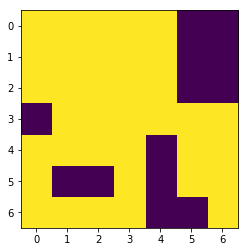

In [19]:
# Use the same weights as above
trainer = DNNSwift.DNN(
    img_dims=(50, 50, 1), 
    labels=img_handler.get_image_groups(), 
    layer_params=dnn_layout, 
    basedir="dnn_output",
    weights=weights)

output = trainer.run_network(input_images=big_image)
output_argmax = np.squeeze(np.argmax(output, axis=3))
plt.imshow(output_argmax)

The output is no longer a single probability vector but a map of probabilities (shown here are only the predicted classes). This corresponds to a segmentation map of the input image. Note that this example is a terrible segmentation because the network was not trained to recognize backgrounds, i.e. it expects each pixel to be either a circle or a square.

Due to the pooling layers and the padding at the edges of convolutions, the output map is smaller than the input image. I have found that if the number of pooling layers is kept small, simply resizing the output map to the original size gives acceptable results. Future versions of tensorflow will contain unpooling layers that will be integrated into the package.

Note that by passing an explicit set of weights to the DNN object, the fully connected layer logic (of reducing the feature map to a single value) is effectively bypassed, making it possible to flexibly use this package for segmentation and classification simultaneously.